In [1]:
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [14]:
input_hl=Input(shape= (7,))
layer=input_hl
layer=Dense(200,activation='relu')(layer)
layer=Dense(400,activation='relu')(layer)
layer=Dense(400,activation='relu')(layer)
layer=Dense(200,activation='relu')(layer)
layer=Dense(100,activation='relu')(layer)
layer=Dense(50,activation='relu')(layer)
layer=Dense(20,activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_hl ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('hlbase.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               1600      
_________________________________________________________________
dense_12 (Dense)             (None, 400)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_14 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
__________

In [70]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)

GPU = 2
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_hlbase.h5')

In [3]:
bg = np.genfromtxt('/pub/daohangt/hep/data/HL/HLVar_bg.csv',delimiter=',')
sig = np.genfromtxt('/pub/daohangt/hep/data/HL/HLVar_sig.csv',delimiter=',')
print(bg.shape, sig.shape)

(118371, 7) (118371, 7)


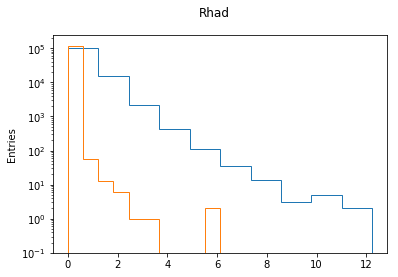

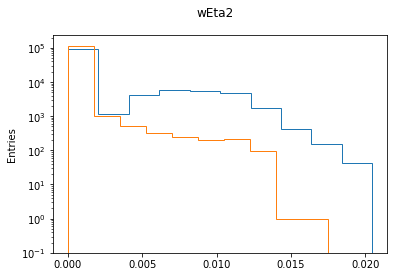

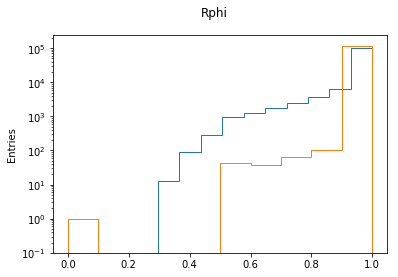

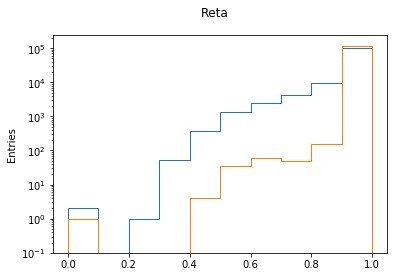

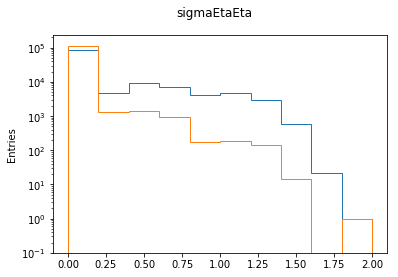

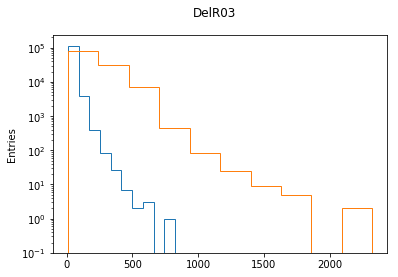

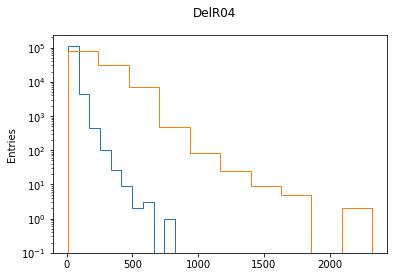

In [17]:
lkup = ["Rhad","wEta2","Rphi","Reta","sigmaEtaEta","DelR03","DelR04"]
for i in range(7):
    fig, ax = plt.subplots()
    ax.hist(bg[:,i],histtype='step',log=True)
    ax.hist(sig[:,i],histtype='step',log=True)
    fig.suptitle(lkup[i], fontsize=12)
    ax.set_ylabel("Entries", fontsize=10)
    plt.show()

In [4]:
x = np.concatenate((bg,sig))
print(bg.shape,sig.shape,x.shape)
y = np.concatenate((np.zeros(bg.shape[0]),np.ones(sig.shape[0])))
print(y.shape)
print(x[119002],y[119002])

(118371, 7) (118371, 7) (236742, 7)
(236742,)
[2.46493e-02 0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 1.44552e+02
 1.44552e+02] 1.0


In [5]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.20, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.20, random_state=42)

In [6]:
# Final check for the shape
def printShape(x):
    for i in x:
        print(i.shape)

printShape((x_tr, x_val, x_te, y_tr, y_val, y_te)) 

(151514, 7)
(37879, 7)
(47349, 7)
(151514,)
(37879,)
(47349,)


In [7]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(t + ' ROC')
    plt.savefig(t+str(roc_auc[0])+".png")
    plt.show()
    
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=10, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [8]:
def run_model(model,x_tr,y_tr,x_val,y_val,p=False,epochs=20,batch=128):
    model.load_weights(('parallel_' if p else '') + 'hlbase.h5')
    history = model.fit(x_tr, y_tr, epochs=epochs, batch_size=128, 
                    validation_data=(x_val,y_val),verbose=1,
                    callbacks=callbacks)
    model.save_weights(('parallel_' if p else '') +'hlbase_'+'_{}e_{}b.h5'.format(epochs,batch))
    plot_al(history, 'loss', 'HL')
    y_hat = model.predict(x_te)
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    roc(y_te, y_hat, 'HL')

Train on 151514 samples, validate on 37879 samples
Epoch 1/200
151514/151514 [==============================] - 6s 37us/step - loss: 0.6748 - val_loss: 0.6936
Epoch 2/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/200
151514/151514 [==============================] - 5s 34us/step - loss: 0.6

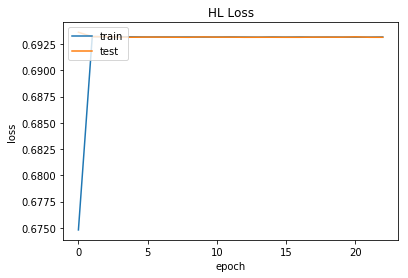

{0: 0.5, 1: 0.5}


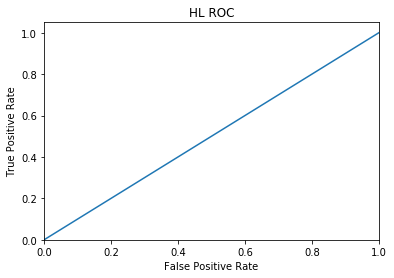

In [15]:
run_model(model,x_tr,y_tr,x_val,y_val,p=False,epochs=200,batch=128)